In [ ]:
## filtro X-11

In [10]:
from LecturaDatos import read_data

In [11]:
df_clean= read_data()

In [19]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from datetime import datetime
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

Procesando datos y realizando descomposición...
Valores faltantes antes de limpieza: 0


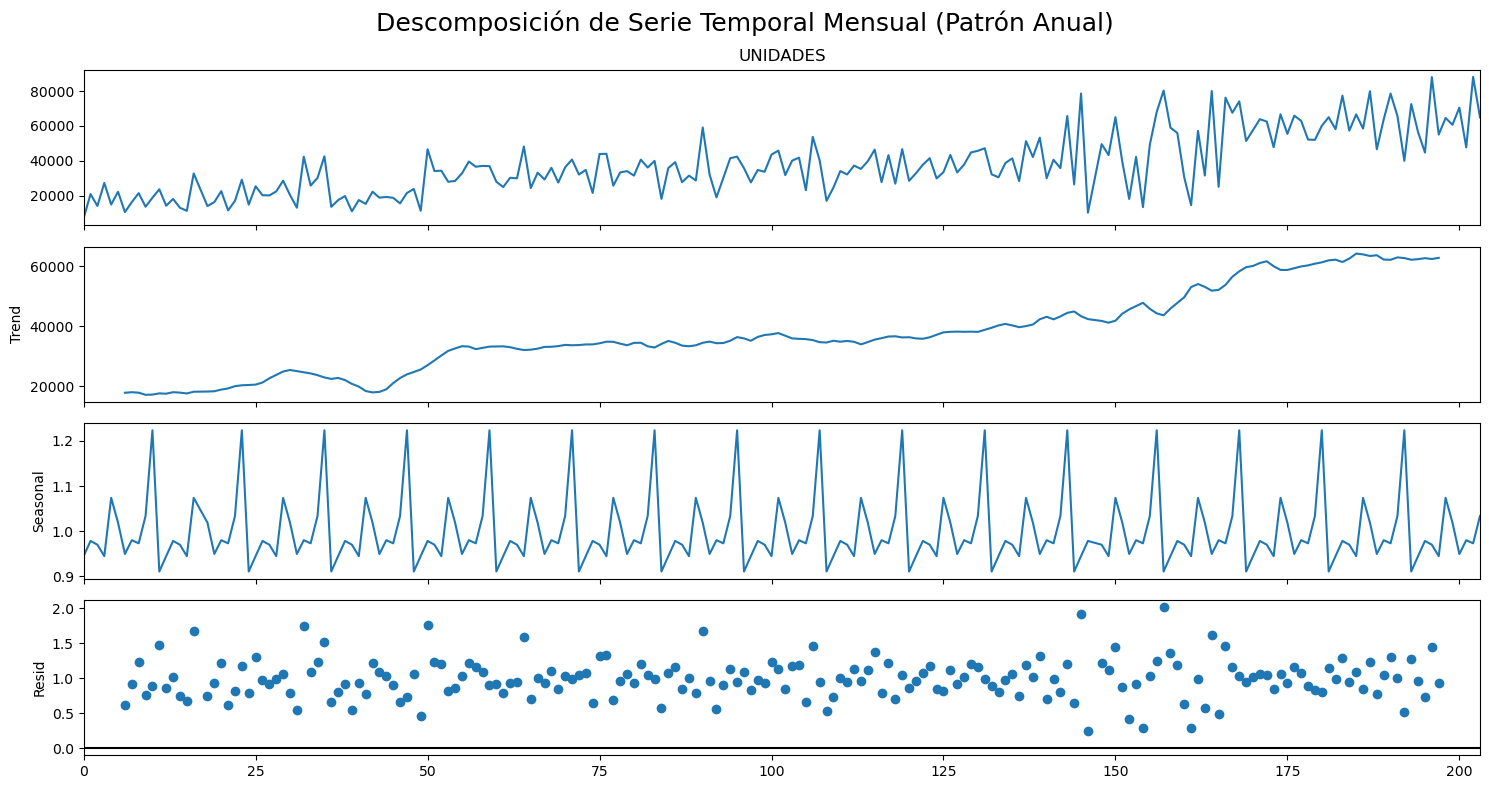

REPORTE DETALLADO DE ANÁLISIS DE SERIE TEMPORAL

📊 ESTADÍSTICAS BÁSICAS POR COMPONENTE
--------------------------------------------------
                n     media   mediana       std       min       max        q1  \
Original   190.00 37,637.18 34,688.00 17,398.86 10,183.00 88,012.00 25,093.25   
Tendencia  190.00 37,684.57 35,135.77 13,386.84 17,118.42 64,198.46 32,080.18   
Estacional 190.00      1.00      0.97      0.08      0.91      1.22      0.95   
Residuos   190.00      1.00      0.99      0.28      0.25      2.02      0.83   

                  q3    cv  asimetria  curtosis  
Original   46,572.50 46.23       0.66     -0.11  
Tendencia  44,029.70 35.52       0.47     -0.57  
Estacional      1.02  8.01       1.73      2.46  
Residuos        1.16 28.33       0.47      1.38  

📈 ANÁLISIS DE TENDENCIA
--------------------------------------------------
• Crecimiento total: 252.6%
• Tasa de crecimiento mensual: 0.67%
• Pendiente: 232.06
• Linealidad (R²): 0.909 (Media)
• Patrón: Ac

In [20]:
class TimeSeriesDetailedAnalyzer:
    def __init__(self, original_series, decomposition_result):
        """
        Inicializar el analizador con la serie original y la descomposición
        
        Parameters:
        original_series: pandas Series con los datos originales
        decomposition_result: resultado de sm.tsa.seasonal_decompose()
        """
        self.original = original_series
        self.decomp = decomposition_result
        self.trend = decomposition_result.trend
        self.seasonal = decomposition_result.seasonal
        self.resid = decomposition_result.resid
        
        # Limpiar NaN values que pueden aparecer al inicio/final de la tendencia
        self.clean_data()
        
    def clean_data(self):
        """Limpiar valores NaN de la descomposición"""
        # Crear máscaras para valores válidos
        valid_mask = ~(self.trend.isna() | self.seasonal.isna() | self.resid.isna())
        
        self.original_clean = self.original[valid_mask]
        self.trend_clean = self.trend[valid_mask]
        self.seasonal_clean = self.seasonal[valid_mask]
        self.resid_clean = self.resid[valid_mask]
        
    def calculate_basic_stats(self):
        """Calcular estadísticas básicas para cada componente"""
        components = {
            'Original': self.original_clean,
            'Tendencia': self.trend_clean,
            'Estacional': self.seasonal_clean,
            'Residuos': self.resid_clean
        }
        
        stats_dict = {}
        
        for name, series in components.items():
            stats_dict[name] = {
                'n': len(series),
                'media': series.mean(),
                'mediana': series.median(),
                'std': series.std(),
                'min': series.min(),
                'max': series.max(),
                'q1': series.quantile(0.25),
                'q3': series.quantile(0.75),
                'cv': (series.std() / abs(series.mean())) * 100 if series.mean() != 0 else np.inf,
                'asimetria': stats.skew(series),
                'curtosis': stats.kurtosis(series)
            }
        
        return stats_dict
    
    def analyze_trend(self):
        """Análisis detallado del componente de tendencia"""
        # Calcular crecimiento total y tasa
        growth_total = ((self.trend_clean.iloc[-1] - self.trend_clean.iloc[0]) / self.trend_clean.iloc[0]) * 100
        growth_monthly = (np.power(self.trend_clean.iloc[-1] / self.trend_clean.iloc[0], 1/len(self.trend_clean)) - 1) * 100
        
        # Regresión lineal para evaluar linealidad
        x = np.arange(len(self.trend_clean))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, self.trend_clean)
        
        # Detectar cambios de tendencia (usando diferencias de segundo orden)
        second_diff = np.diff(np.diff(self.trend_clean))
        change_points = np.where(np.abs(second_diff) > 2 * np.std(second_diff))[0]
        
        # Aceleration/deceleración
        first_half_slope = stats.linregress(x[:len(x)//2], self.trend_clean.iloc[:len(x)//2])[0]
        second_half_slope = stats.linregress(x[len(x)//2:], self.trend_clean.iloc[len(x)//2:])[0]
        
        return {
            'crecimiento_total_pct': growth_total,
            'crecimiento_mensual_pct': growth_monthly,
            'pendiente': slope,
            'r_cuadrado': r_value**2,
            'p_valor': p_value,
            'linealidad': 'Alta' if r_value**2 > 0.95 else 'Media' if r_value**2 > 0.85 else 'Baja',
            'puntos_cambio': len(change_points),
            'aceleracion': 'Acelerando' if second_half_slope > first_half_slope * 1.1 else 
                          'Desacelerando' if second_half_slope < first_half_slope * 0.9 else 'Estable',
            'error_estandar': std_err
        }
    
    def analyze_seasonality(self):
        """Análisis detallado del componente estacional"""
        # Reshape para análisis por período (asumiendo periodicidad anual = 12)
        period = 12
        n_years = len(self.seasonal_clean) // period
        seasonal_matrix = self.seasonal_clean[:n_years * period].values.reshape(n_years, period)
        
        # Estabilidad de la estacionalidad a lo largo de los años
        seasonal_std_by_month = np.std(seasonal_matrix, axis=0)
        seasonal_stability = np.mean(seasonal_std_by_month)
        
        # Fuerza de la estacionalidad
        seasonal_range = self.seasonal_clean.max() - self.seasonal_clean.min()
        seasonal_amplitude = seasonal_range / 2
        
        # Identificar meses pico y valle
        monthly_avg = np.mean(seasonal_matrix, axis=0)
        peak_month = np.argmax(monthly_avg) + 1
        trough_month = np.argmin(monthly_avg) + 1
        
        # Simetría del patrón estacional
        seasonal_skewness = stats.skew(monthly_avg)
        
        return {
            'amplitud': seasonal_amplitude,
            'rango': seasonal_range,
            'estabilidad': seasonal_stability,
            'estabilidad_nivel': 'Alta' if seasonal_stability < 0.05 else 'Media' if seasonal_stability < 0.1 else 'Baja',
            'mes_pico': peak_month,
            'mes_valle': trough_month,
            'valor_pico': monthly_avg[peak_month-1],
            'valor_valle': monthly_avg[trough_month-1],
            'asimetria': seasonal_skewness,
            'patron': 'Simétrico' if abs(seasonal_skewness) < 0.5 else 'Asimétrico',
            'fuerza': 'Fuerte' if seasonal_amplitude > 0.15 else 'Moderada' if seasonal_amplitude > 0.08 else 'Débil'
        }
    
    def analyze_residuals(self):
        """Análisis detallado de los residuos"""
        # Detección de outliers (usando IQR y Z-score)
        Q1 = self.resid_clean.quantile(0.25)
        Q3 = self.resid_clean.quantile(0.75)
        IQR = Q3 - Q1
        outliers_iqr = self.resid_clean[(self.resid_clean < Q1 - 1.5*IQR) | (self.resid_clean > Q3 + 1.5*IQR)]
        
        z_scores = np.abs(stats.zscore(self.resid_clean))
        outliers_zscore = self.resid_clean[z_scores > 2]
        
        # Prueba de normalidad
        shapiro_stat, shapiro_p = stats.shapiro(self.resid_clean[:5000] if len(self.resid_clean) > 5000 else self.resid_clean)
        
        # Autocorrelación de residuos (Ljung-Box test)
        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox
            ljung_box = acorr_ljungbox(self.resid_clean, lags=10, return_df=True)
            autocorrelation_p = ljung_box['lb_pvalue'].iloc[-1]
        except:
            autocorrelation_p = None
        
        # Heterocedasticidad
        # Dividir en dos mitades y comparar varianzas
        mid_point = len(self.resid_clean) // 2
        first_half_var = self.resid_clean[:mid_point].var()
        second_half_var = self.resid_clean[mid_point:].var()
        variance_ratio = max(first_half_var, second_half_var) / min(first_half_var, second_half_var)
        
        return {
            'outliers_iqr': len(outliers_iqr),
            'outliers_zscore': len(outliers_zscore),
            'pct_outliers': (len(outliers_iqr) / len(self.resid_clean)) * 100,
            'normalidad_shapiro_p': shapiro_p,
            'es_normal': shapiro_p > 0.05,
            'autocorrelacion_p': autocorrelation_p,
            'independiente': autocorrelation_p > 0.05 if autocorrelation_p else 'No evaluado',
            'ratio_varianzas': variance_ratio,
            'homoscedastico': variance_ratio < 2,
            'media_residuos': self.resid_clean.mean(),
            'std_residuos': self.resid_clean.std()
        }
    
    def calculate_model_quality(self):
        """Evaluar la calidad general del modelo"""
        # R² del modelo completo
        ss_res = np.sum(self.resid_clean ** 2)
        ss_tot = np.sum((self.original_clean - self.original_clean.mean()) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # MAE y RMSE
        reconstructed = self.trend_clean * self.seasonal_clean
        mae = mean_absolute_error(self.original_clean, reconstructed)
        rmse = np.sqrt(mean_squared_error(self.original_clean, reconstructed))
        
        # MAPE
        mape = np.mean(np.abs((self.original_clean - reconstructed) / self.original_clean)) * 100
        
        # Porcentaje de varianza explicada por cada componente
        trend_var = self.trend_clean.var()
        seasonal_var = self.seasonal_clean.var()
        resid_var = self.resid_clean.var()
        total_var = trend_var + seasonal_var + resid_var
        
        return {
            'r_cuadrado': r_squared,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'calidad': 'Excelente' if r_squared > 0.95 else 'Muy Buena' if r_squared > 0.90 else 
                      'Buena' if r_squared > 0.80 else 'Regular' if r_squared > 0.70 else 'Pobre',
            'var_tendencia_pct': (trend_var / total_var) * 100,
            'var_estacional_pct': (seasonal_var / total_var) * 100,
            'var_residuos_pct': (resid_var / total_var) * 100
        }
    
    def generate_comprehensive_report(self):
        """Generar reporte completo del análisis"""
        print("="*80)
        print("REPORTE DETALLADO DE ANÁLISIS DE SERIE TEMPORAL")
        print("="*80)
        
        # Estadísticas básicas
        basic_stats = self.calculate_basic_stats()
        print("\n📊 ESTADÍSTICAS BÁSICAS POR COMPONENTE")
        print("-" * 50)
        
        stats_df = pd.DataFrame(basic_stats).T
        print(stats_df.round(2))
        
        # Análisis de tendencia
        trend_analysis = self.analyze_trend()
        print(f"\n📈 ANÁLISIS DE TENDENCIA")
        print("-" * 50)
        print(f"• Crecimiento total: {trend_analysis['crecimiento_total_pct']:.1f}%")
        print(f"• Tasa de crecimiento mensual: {trend_analysis['crecimiento_mensual_pct']:.2f}%")
        print(f"• Pendiente: {trend_analysis['pendiente']:.2f}")
        print(f"• Linealidad (R²): {trend_analysis['r_cuadrado']:.3f} ({trend_analysis['linealidad']})")
        print(f"• Patrón: {trend_analysis['aceleracion']}")
        print(f"• Puntos de cambio detectados: {trend_analysis['puntos_cambio']}")
        
        # Análisis estacional
        seasonal_analysis = self.analyze_seasonality()
        print(f"\n🔄 ANÁLISIS DE ESTACIONALIDAD")
        print("-" * 50)
        print(f"• Fuerza estacional: {seasonal_analysis['fuerza']}")
        print(f"• Amplitud: {seasonal_analysis['amplitud']:.3f}")
        print(f"• Rango: {seasonal_analysis['rango']:.3f}")
        print(f"• Estabilidad: {seasonal_analysis['estabilidad_nivel']}")
        print(f"• Mes pico: {seasonal_analysis['mes_pico']} (valor: {seasonal_analysis['valor_pico']:.3f})")
        print(f"• Mes valle: {seasonal_analysis['mes_valle']} (valor: {seasonal_analysis['valor_valle']:.3f})")
        print(f"• Patrón: {seasonal_analysis['patron']}")
        
        # Análisis de residuos
        residual_analysis = self.analyze_residuals()
        print(f"\n📊 ANÁLISIS DE RESIDUOS")
        print("-" * 50)
        print(f"• Outliers detectados: {residual_analysis['outliers_iqr']} ({residual_analysis['pct_outliers']:.1f}%)")
        print(f"• Distribución normal: {'Sí' if residual_analysis['es_normal'] else 'No'} (p={residual_analysis['normalidad_shapiro_p']:.4f})")
        print(f"• Independencia: {residual_analysis['independiente']}")
        print(f"• Homocedasticidad: {'Sí' if residual_analysis['homoscedastico'] else 'No'} (ratio={residual_analysis['ratio_varianzas']:.2f})")
        print(f"• Media de residuos: {residual_analysis['media_residuos']:.4f}")
        
        # Calidad del modelo
        model_quality = self.calculate_model_quality()
        print(f"\n🎯 CALIDAD DEL MODELO")
        print("-" * 50)
        print(f"• R² global: {model_quality['r_cuadrado']:.3f}")
        print(f"• Calidad: {model_quality['calidad']}")
        print(f"• MAE: {model_quality['mae']:.2f}")
        print(f"• RMSE: {model_quality['rmse']:.2f}")
        print(f"• MAPE: {model_quality['mape']:.1f}%")
        print(f"\n📊 CONTRIBUCIÓN DE VARIANZA:")
        print(f"• Tendencia: {model_quality['var_tendencia_pct']:.1f}%")
        print(f"• Estacional: {model_quality['var_estacional_pct']:.1f}%")
        print(f"• Residuos: {model_quality['var_residuos_pct']:.1f}%")
        
        # Interpretación y recomendaciones
        self.generate_recommendations(trend_analysis, seasonal_analysis, residual_analysis, model_quality)
        
        return {
            'basic_stats': basic_stats,
            'trend_analysis': trend_analysis,
            'seasonal_analysis': seasonal_analysis,
            'residual_analysis': residual_analysis,
            'model_quality': model_quality
        }
    
    def generate_recommendations(self, trend_analysis, seasonal_analysis, residual_analysis, model_quality):
        """Generar recomendaciones basadas en el análisis"""
        print(f"\n💡 INTERPRETACIÓN Y RECOMENDACIONES")
        print("=" * 50)
        
        print("🔍 FORTALEZAS DEL MODELO:")
        if model_quality['r_cuadrado'] > 0.90:
            print("• Excelente ajuste del modelo (R² > 0.90)")
        if trend_analysis['linealidad'] == 'Alta':
            print("• Tendencia muy lineal y predecible")
        if seasonal_analysis['estabilidad_nivel'] == 'Alta':
            print("• Patrón estacional muy estable")
        if residual_analysis['pct_outliers'] < 5:
            print("• Pocos valores atípicos en los residuos")
        
        print("\n⚠️  PUNTOS DE ATENCIÓN:")
        if model_quality['r_cuadrado'] < 0.80:
            print("• Considerar modelo más complejo o variables adicionales")
        if residual_analysis['pct_outliers'] > 10:
            print(f"• Alto porcentaje de outliers ({residual_analysis['pct_outliers']:.1f}%)")
        if not residual_analysis['es_normal']:
            print("• Residuos no siguen distribución normal")
        if not residual_analysis['homoscedastico']:
            print("• Presencia de heterocedasticidad en residuos")
        if seasonal_analysis['estabilidad_nivel'] == 'Baja':
            print("• Patrón estacional inestable - monitorear cambios")
        
        print("\n🚀 RECOMENDACIONES OPERATIVAS:")
        if seasonal_analysis['fuerza'] in ['Fuerte', 'Moderada']:
            print(f"• Planificar recursos para pico en mes {seasonal_analysis['mes_pico']}")
            print(f"• Optimizar inventario considerando valle en mes {seasonal_analysis['mes_valle']}")
        
        if trend_analysis['aceleracion'] == 'Acelerando':
            print("• Tendencia acelerando - preparar capacidad adicional")
        elif trend_analysis['aceleracion'] == 'Desacelerando':
            print("• Tendencia desacelerando - revisar estrategias de crecimiento")
        
        growth_annual = trend_analysis['crecimiento_mensual_pct'] * 12
        print(f"• Proyección anual basada en tendencia: ~{growth_annual:.1f}%")

# =====================================================
# USO CON TUS DATOS EXISTENTES
# =====================================================

# Tu código existente (modificado ligeramente):
print("Procesando datos y realizando descomposición...")

# 1. Verificar y limpiar valores faltantes
print("Valores faltantes antes de limpieza:", df_clean['UNIDADES'].isna().sum())

# 2. Limpiar datos
df_clean = df_clean.dropna(subset=['UNIDADES'])

# 3. Verificar que no queden NA
if df_clean['UNIDADES'].isna().any():
    raise ValueError("La serie todavía contiene valores faltantes después de la limpieza")

# 4. Descomposición estacional
try:
    decomposition_entidad = sm.tsa.seasonal_decompose(
        df_clean['UNIDADES'], 
        model='multiplicative', 
        period=12
    )
    
    # 5. Crear el analizador detallado
    analyzer = TimeSeriesDetailedAnalyzer(df_clean['UNIDADES'], decomposition_entidad)
    
    # 6. Generar gráfico original
    fig = decomposition_entidad.plot()
    fig.set_figwidth(15)
    fig.set_figheight(8)
    fig.suptitle('Descomposición de Serie Temporal Mensual (Patrón Anual)', size=18)
    plt.tight_layout()
    plt.show()
    
    # 7. ANÁLISIS DETALLADO
    detailed_results = analyzer.generate_comprehensive_report()
    
    # 8. GRÁFICOS ADICIONALES DETALLADOS
    analyzer.plot_detailed_analysis()
    
except Exception as e:
    print(f"Error en la descomposición: {str(e)}")
    print("\nPosibles soluciones:")
    print("- Verificar que hay suficientes datos (mínimo 2 períodos completos)")
    print("- Revisar que la frecuencia de tiempo sea consistente")
    print("- Probar con model='additive' si hay valores cero o negativos")

# =====================================================
# FUNCIÓN ADICIONAL PARA GRÁFICOS DETALLADOS
# =====================================================

def plot_detailed_analysis(analyzer):
    """Crear gráficos adicionales detallados"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis Detallado de Componentes', fontsize=16)
    
    # 1. Distribución de residuos
    axes[0,0].hist(analyzer.resid_clean, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(analyzer.resid_clean.mean(), color='red', linestyle='--', label=f'Media: {analyzer.resid_clean.mean():.3f}')
    axes[0,0].set_title('Distribución de Residuos')
    axes[0,0].set_xlabel('Residuos')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].legend()
    
    # 2. Q-Q plot de residuos
    stats.probplot(analyzer.resid_clean, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot de Residuos')
    
    # 3. Residuos vs tiempo
    axes[0,2].plot(analyzer.resid_clean, alpha=0.7)
    axes[0,2].axhline(y=0, color='red', linestyle='--')
    axes[0,2].set_title('Residuos vs Tiempo')
    axes[0,2].set_xlabel('Tiempo')
    axes[0,2].set_ylabel('Residuos')
    
    # 4. Boxplot estacional
    if len(analyzer.seasonal_clean) >= 24:  # Al menos 2 años
        period = 12
        n_years = len(analyzer.seasonal_clean) // period
        seasonal_matrix = analyzer.seasonal_clean[:n_years * period].values.reshape(n_years, period)
        axes[1,0].boxplot(seasonal_matrix, labels=[f'M{i+1}' for i in range(12)])
        axes[1,0].set_title('Variabilidad Estacional por Mes')
        axes[1,0].set_xlabel('Mes')
        axes[1,0].set_ylabel('Factor Estacional')
    
    # 5. Tendencia con intervalos de confianza
    x = np.arange(len(analyzer.trend_clean))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, analyzer.trend_clean)
    line = slope * x + intercept
    
    axes[1,1].plot(analyzer.trend_clean, label='Tendencia Real', linewidth=2)
    axes[1,1].plot(line, '--', label=f'Regresión Lineal (R²={r_value**2:.3f})', color='red')
    axes[1,1].fill_between(x, line - 1.96*std_err*np.sqrt(1 + 1/len(x) + (x - x.mean())**2/np.sum((x - x.mean())**2)), 
                          line + 1.96*std_err*np.sqrt(1 + 1/len(x) + (x - x.mean())**2/np.sum((x - x.mean())**2)), 
                          alpha=0.2, color='red')
    axes[1,1].set_title('Tendencia con Intervalo de Confianza')
    axes[1,1].legend()
    
    # 6. Autocorrelación de residuos
    from statsmodels.tsa.stattools import acf
    try:
        autocorr = acf(analyzer.resid_clean, nlags=20, fft=False)
        lags = np.arange(len(autocorr))
        axes[1,2].bar(lags, autocorr, alpha=0.7)
        axes[1,2].axhline(y=0, color='black', linestyle='-')
        axes[1,2].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
        axes[1,2].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
        axes[1,2].set_title('Autocorrelación de Residuos')
        axes[1,2].set_xlabel('Lag')
        axes[1,2].set_ylabel('Autocorrelación')
    except:
        axes[1,2].text(0.5, 0.5, 'Error en cálculo\nde autocorrelación', 
                      transform=axes[1,2].transAxes, ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Agregar método a la clase
TimeSeriesDetailedAnalyzer.plot_detailed_analysis = plot_detailed_analysis
# Tu código existente de X-11...
decomposition = seasonal_decompose(df_clean['UNIDADES'], model='multiplicative', period=12)

# Calcular residuos
mask_valid = (decomposition.trend.notna() & decomposition.seasonal.notna())
valores_ajustados = decomposition.trend[mask_valid] * decomposition.seasonal[mask_valid]
residuos = df_clean['UNIDADES'][mask_valid] - valores_ajustados



In [18]:
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Suponiendo que ya tienes los residuos del modelo X-11
# (por ejemplo: residuos = decomposition.resid.dropna())
residuos = residuos.dropna()

# === Prueba Jarque–Bera ===
jb_stat, jb_p, skew, kurt = jarque_bera(residuos)
print(f"Jarque–Bera → JB: {jb_stat:.4f} | p-valor: {jb_p:.4f}")

# === Prueba Shapiro–Wilk ===
sw_stat, sw_p = shapiro(residuos)
print(f"Shapiro–Wilk → SW: {sw_stat:.4f} | p-valor: {sw_p:.4f}")

# === Interpretación rápida ===
if jb_p > 0.05 and sw_p > 0.05:
    print("✅ Residuos normales según ambas pruebas.")
else:
    print("⚠️ Los residuos no son normales.")



Jarque–Bera → JB: 50.7358 | p-valor: 0.0000
Shapiro–Wilk → SW: 0.9492 | p-valor: 0.0000
⚠️ Los residuos no son normales.
